In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set(style="darkgrid")
from scipy import stats
import matplotlib.patches as mpatches

In [2]:
data_types = {'Recall Notification Date': str}
df = pd.read_csv("database.csv", dtype=data_types)

In [3]:
df.dtypes

Record ID                     int64
NHTSA Campaign               object
Manufacturer Campaign        object
Vehicle Make                 object
Vehicle Model                object
Model Year                    int64
Vehicle Manufacturer         object
Recall Type                  object
Recall Component             object
Manufacture Start Date      float64
Manufacture End Date        float64
Estimated Units             float64
Recall Initiative            object
Recall Manufacturer          object
Recall Notification Date     object
dtype: object

In [4]:
ford_aliases = {
    'FORD MOTOR COMPANY',
    'FORD MOTOR COMPANY test adw as',
    'FORD MTR CO-OVERSEAS',
    'Ford Motor Company'
}

In [5]:
ford_df = df.loc[df['Vehicle Manufacturer'].isin(ford_aliases)]

In [6]:
ford_df_over_500k = ford_df.loc[df['Estimated Units'] > 500000.0]

In [7]:
len(ford_df_over_500k)

1145

In [8]:
ford_df_filtered = ford_df_over_500k.dropna(subset=['Recall Notification Date'])

In [9]:
ford_df_filtered_with_date = ford_df_filtered['Recall Notification Date'].apply(lambda x:pd.datetime.strptime(x, '%Y%m%d'))

In [10]:
type(ford_df_filtered['Estimated Units'])

pandas.core.series.Series

In [11]:
date_split_value = pd.datetime(1995, 1, 1) # ignore values before 1995

In [12]:
recalls_by_units_df = pd.DataFrame({
        'Recall Notification Date': ford_df_filtered_with_date,
        'Estimated Units': ford_df_filtered['Estimated Units']
})

In [13]:
recalls_by_units_df_after_1995 = recalls_by_units_df.loc[recalls_by_units_df['Recall Notification Date'] > date_split_value]

In [14]:
recalls_by_unit_after_1995_unique = recalls_by_units_df_after_1995.drop_duplicates()

In [15]:
ford_stock_data_types = {
    'Date': str,
    'Price': float
}
ford_stock = pd.read_csv('zstock_data_clean/ford_stock.txt', sep='\t', parse_dates=['Date'])

In [16]:
ford_stock_after_1995 = ford_stock.loc[ford_stock['Date'] > date_split_value]

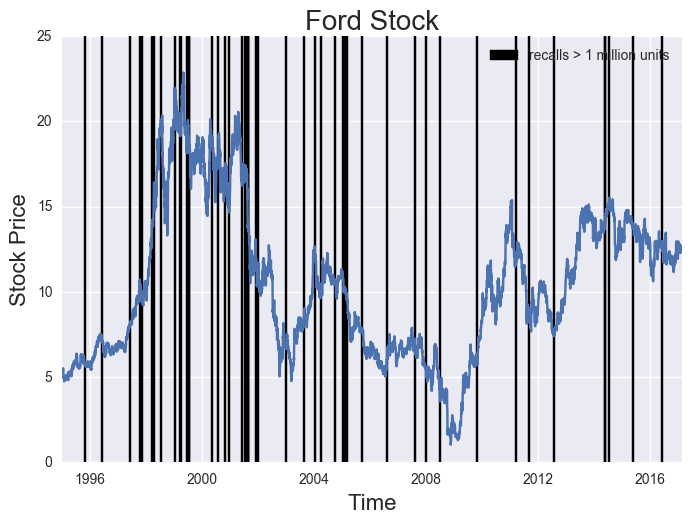

In [17]:
plt.plot(list(ford_stock_after_1995['Date']), list(ford_stock_after_1995['Price']))
#plt.scatter(list(recalls_by_unit_after_1995_unique['Recall Notification Date']), [25 for x in range(0, len(recalls_by_unit_after_1995_unique))])
#for i in range(0, len(recalls_by_unit_after_1995_unique))
#    plt.plot([, ])
my_dates_list = list(recalls_by_unit_after_1995_unique['Recall Notification Date'])
plt.vlines(x=my_dates_list, ymin=[0 for x in range(0, len(my_dates_list))], ymax=[25 for x in range(0, len(my_dates_list))])
plt.title('Ford Stock', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
black_patch = mpatches.Patch(color='black', label='recalls > 1 million units')
plt.legend(handles=[black_patch],
           loc='upper right')
plt.show()

In [18]:
type(ford_stock_after_1995['Date'][5707])

pandas.tslib.Timestamp

In [19]:
type(recalls_by_unit_after_1995_unique['Recall Notification Date'][4605])

pandas.tslib.Timestamp

In [20]:
ford_stock_after_1995_reset_indices = ford_stock_after_1995.reset_index()
ford_stock_after_1995_reset_indices.drop('index', axis=1, inplace=True)

In [21]:
# now we will conduct the event study
dates_arr = np.array(ford_stock_after_1995_reset_indices['Date'])
prices_arr = np.array(ford_stock_after_1995_reset_indices['Price'])
recalls_dates_arr = np.array(recalls_by_unit_after_1995_unique['Recall Notification Date'])

In [22]:
len(dates_arr)

5577

In [23]:
len(recalls_dates_arr)

48

In [24]:
#recalls_dates_arr

In [87]:
estimation_window = 100
event_window = 100

In [88]:
import event_study.event_study as evt

In [89]:
t_statistic, stdev, caar, car, abnormal_returns, bases = evt.event_study(stock_date_data=dates_arr,
                                                                           stock_price_data=prices_arr,
                                                                           event_dates=recalls_dates_arr,
                                                                           estimation_window=estimation_window,
                                                                           event_window=event_window)
print("t statistic:", t_statistic)
print("stdev: ", stdev)

t statistic: -1.69818996186
stdev:  0.331968392885


In [90]:
import random as random

In [91]:
def generate_random_dates(number_of_random_numbers):
    number_of_random_numbers = 30
    randoms = set()
    for i in range(0, number_of_random_numbers):
        r = random.randrange(0, len(ford_stock_after_1995_reset_indices))
        while r < event_window or r > len(ford_stock_after_1995_reset_indices) - event_window:
            r = random.randrange(0, len(ford_stock_after_1995_reset_indices))
        randoms.add(r)
    random_dates_series = ford_stock_after_1995_reset_indices['Date'][randoms]
    random_dates = [np.datetime64(the_date) for the_date in list(random_dates_series)]
    random_dates = np.array(random_dates)
    return random_dates

In [92]:
n_random_numbers = 30
random_dates = generate_random_dates(n_random_numbers)

In [93]:
def simulate_event_study(num_simulations, est_win, evt_win):
    t_statistics = []
    p_values = []
    for i in range(0, num_simulations):
        random_dates = generate_random_dates(30)
        t_stat, stdev, caar, car, abnormal_returns, bases = evt.event_study(stock_date_data=dates_arr,
                                                                               stock_price_data=prices_arr,
                                                                               event_dates=random_dates,
                                                                               estimation_window=est_win,
                                                                               event_window=evt_win)
        t_statistics.append(t_stat)
        p_value = stats.t.cdf(x=t_stat, df=len(random_dates)-1)
        p_values.append(p_value)
    return t_statistics, p_values

In [94]:
import scipy.stats as stats

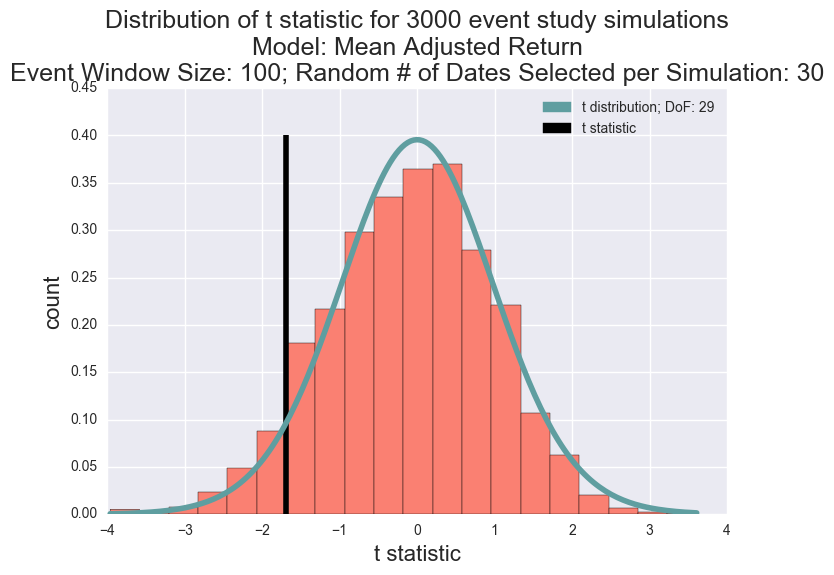

In [95]:
# simulate the t statistic
n_simulations = 3000
t_stats, p_vals = simulate_event_study(n_simulations, est_win=estimation_window, evt_win=event_window)

DoF = len(random_dates) - 1
x = np.linspace(min(t_stats), max(t_stats), 200)
y = stats.t.pdf(x, DoF)

t_curve_color = 'cadetblue'
line_color = 'black'

plt.plot(x, y, c=t_curve_color, linewidth=4)

plt.vlines(x=t_statistic, ymin=0, ymax=0.4, linewidth=4)

plt.hist(t_stats, bins=20, normed=True, color='salmon')
plt.title('Distribution of t statistic for {:d} event study simulations\nModel: Mean Adjusted Return\nEvent Window Size: {:2d}; Random # of Dates Selected per Simulation: {:d}'.format(n_simulations, event_window, len(random_dates)), fontsize=18)
plt.ylabel('count', fontsize=16)
plt.xlabel('t statistic', fontsize=16)

t_curve_patch = mpatches.Patch(color=t_curve_color, label='t distribution; DoF: {:d}'.format(DoF))
t_statistic_line_patch = mpatches.Patch(color=line_color, label='t statistic')

plt.legend(handles=[t_curve_patch, t_statistic_line_patch],
           loc='upper right')

plt.show()

In [96]:
sorted_t_statistics = sorted(t_stats)
n_elems_less_than_t_stat = len([x for x in sorted_t_statistics if x < t_statistic])
pr_less_than_t_stat = n_elems_less_than_t_stat / n_simulations
pr_less_than_t_stat

0.06633333333333333

In [ ]:
n_simulations = 300
t_stats_over_evt_win = []
the_range = range(10, 105, 5)
for window in the_range:
    the_t_statistic, stdev, caar, car, abnormal_returns, bases = evt.event_study(stock_date_data=dates_arr,
                                                                           stock_price_data=prices_arr,
                                                                           event_dates=recalls_dates_arr,
                                                                           estimation_window=window,
                                                                           event_window=window)
    the_t_statistics, the_p_values = simulate_event_study(n_simulations, est_win=window, evt_win=window)
    the_sorted_t_stats = sorted(the_t_statistics)
    the_n_elems_less_than_t_stat = len([x for x in the_sorted_t_stats if x < the_t_statistic])
    pr_less_than_t_stat = the_n_elems_less_than_t_stat / n_simulations
    t_stats_over_evt_win.append(pr_less_than_t_stat)

In [ ]:
t_stats_over_evt_win

In [ ]:
plt.plot(the_range, t_stats_over_evt_win)
plt.title('Simulations showing p value by event window size')
plt.xlabel('event window size')
plt.ylabel('p value')
plt.xlim((min(the_range), max(the_range)))
plt.show()